In [20]:
import pandas as pd
import numpy as np
import iris
import cis
from cis.data_io.gridded_data import make_from_cube

import iris.quickplot as qplt
import cartopy.crs as ccrs
from tqdm import tqdm_notebook

import tensorflow as tf
from GCEm.utils import GPModel_IC, GPModel, plot_parameter_space, plot_maps, plot_histogram_comparison, validation_plot

import os

import matplotlib.pyplot as plt
%matplotlib inline

# GPU = "1"

# os.environ["CUDA_VISIBLE_DEVICES"] = GPU

# Read in the parameters and observables

In [2]:
N_SAMPLES = int(1e6)

constraint_cache_path = "/home/ubuntu/A-CURE-project/constrained_params_OBS_Aeronet/"
obs_path = '/mnt/acure_data/obs/'

if not os.path.isdir(constraint_cache_path):
    os.mkdir(constraint_cache_path)

X_df = pd.read_csv('/mnt/acure_data/26aer/design/Unit_UKCA26aerPPE_TrainingDesign.csv')
X = X_df.values

X_TEST_df = pd.read_csv("/mnt/acure_data/26aer/design/Unit_UKCA26aerPPE_ValidationDesign.csv")
X_TEST = X_TEST_df.values

N_TRAIN, N_PARAMS = X.shape

In [3]:
def load_callback(cube, field, fname):
    cube.attributes = None
#     cube.attributes
    cube.add_dim_coord(iris.coords.DimCoord(np.arange(235), var_name='job'), (0,))

ari = iris.util.squeeze(iris.load("/mnt/acure_data/26aer/ARI_pm2008???_N48.nc", callback=load_callback).concatenate_cube())

train_ari = ari[:N_TRAIN]
test_ari = ari[N_TRAIN:]
    

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'hybrid_ht_1' invalid units 'level'
  warnings.warn(msg)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'hybrid_ht_1' invalid units 'level'
  warnings.warn(msg)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'hybrid_ht_1' invalid units 'level'
  warnings.warn(msg)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'hybrid_ht_1' invalid units 'level'
  warnings.warn(msg)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/i

In [4]:
train_ari

<iris 'Cube' of Aerosol-Radiation Interactions / (1) (job: 183; t: 12; latitude: 73; longitude: 96)>

In [5]:
test_ari

<iris 'Cube' of Aerosol-Radiation Interactions / (1) (job: 52; t: 12; latitude: 73; longitude: 96)>

all_aod_550 = iris.load_cube("/mnt/acure_data/26aer/TOT_AOD_N48.nc", iris.Constraint(wavelength=0.55))
all_aod_550.coord('t').rename('time')

In [6]:
# from iris.pandas import as_cube
# from pandas import DataFrame, read_csv

# df = pd.read_csv(obs_path+'26PPE_colloc_AERONET_AOT550_job_monthly_average_Kinne2013.csv')
# lat_lons = df[['latitude', 'longitude']]
# df = df.drop(columns=['latitude', 'longitude'])

# all_aod_550 = as_cube(df.T)
# all_aod_550.var_name='AOD_550'
# all_aod_550.add_dim_coord(iris.coords.DimCoord(range(235), var_name='job'), 0)
# all_aod_550.remove_coord('index')
# print(all_aod_550)

AOD_550 / (unknown)                 (job: 235; columns: 52)
     Dimension coordinates:
          job                           x             -
          columns                       -             x


In [7]:
all_aod_550 = iris.load_cube("/mnt/acure_data/obs/AOD550_26PPE_colloc_on_AERONET_monthly_jul2008.nc")
all_aod_550

<iris 'Cube' of Model AOD sampled at Aeronet station locations / (1) (job: 235; obs: 52)>

In [8]:
sample_file = "/mnt/acure_data/26aer/RLHSamp_1Mcombs_MargUnif_Sample1.nc"
if os.path.isfile(sample_file):
    print("Using pre-generated sample points")
    large_sample = iris.load_cube(sample_file, 'InputsSample').data.T
else:
    print("Using randomly generated sample points")
    large_sample = tf.random_uniform([N_SAMPLES, N_PARAMS], dtype=D_TYPE)
    

Using pre-generated sample points


# Read in the actual observations

from cis.time_util import PartialDateTime
from glob import glob

aeronet_aod_2008 = [cis.read_data(f, 'AOT_500').subset(time=PartialDateTime(2008)) for f in glob(obs_path+'*.lev20')]


In [9]:
aeronet_aod_2008_df =pd.read_csv(obs_path+'AERONET_AOT550_monthly_average_Kinne2013.csv')
aeronet_aod_2008_df

,latitude,longitude,Aerosol Optical Thickness
0,-37.810001,77.572998,0.073498
1,-34.567001,301.500000,0.211746
2,-20.438000,305.462006,0.064912
3,-18.472000,289.687012,0.300517
4,-16.108000,128.748993,0.040344
5,-15.729000,303.979004,0.082724
6,-10.934000,298.148010,0.099816
7,-9.957000,292.131012,0.131557
8,-9.871000,303.895996,0.065743
9,-9.383000,319.500000,0.033765


In [10]:
#combined_aeronet_aod_2008_monthly = np.hstack(d.as_data_frame().groupby(pd.Grouper(freq='D')).mean()['AOT_500'].dropna().values for d in aeronet_aod_2008)

# Collocate the model and obs

In [11]:
train_aod = all_aod_550[:N_TRAIN]
test_aod = all_aod_550[N_TRAIN:]

# Setup and run the models

In [12]:

class IndependentObsConstraint():
    def __init__(self, training_data, obs, log_obs, name='', *args, **kwargs):
        
        self.name = name
        self.log_obs = log_obs
        self.obs = obs
        # Calculate the variabiltiy across the training data
        self.var_obs = training_data.collapsed('job', iris.analysis.STD_DEV).data.flatten()
        
        t_data = training_data.data if isinstance(training_data, iris.cube.Cube) else training_data
        
        self.models = []
        # Create a model for each 'observation'
        flat_Y = t_data.reshape((training_data.shape[0], -1))
        for i, y in enumerate(flat_Y.T):
            self.models.append(GPModel_IC(y, 'Obs {}'.format(i)))
            
    def constrain_implaus(self, sample_points, 
                          obs_var=0.5, interann_var=0.0, repres_var=0.1, struct_var=0.0,
                          tolerance=0.9, threshold=2.0):

        means = []
        variances = []

        for m in tqdm_notebook(self.models):
            with m.sess.as_default(), m.sess.graph.as_default():
                mean, var = m.model.predict_y(sample_points)
            means.append(mean[:, 0])
            variances.append(var[:, 0])

        pred_mean = np.stack(means)
        pred_var = np.stack(variances)

        ##################################################################
        ## Make the denominator variance error term that comes from the 'Emulator Uncertainty'
        ##  -> Different for each input combinations in the InputsSample
        ##  -> Taken directly from DiceKriging prediction$sd
        ##################################################################
        EmVarVec = pred_var

        ####################################################################################
        ## Make the denominator variance error term that comes from the 'Observational Measurement Uncertainty'
        ##  -> Take as a percentage error on the observation value
        ##  -> Obs measured to within +/- %age of their value
        ##  -> Assume Gaussian distribution and equate (+/- %age/100)*obs to 95% Gaussian Confidence Interval, of ~ +/-2*StDev 
        ##  -> Is currently the same for all input combinations (model variants)
        ####################################################################################

        ObsMeasSD = self.obs[:, np.newaxis] * (obs_var/100)/2
        ObsMeasVar = ObsMeasSD ** 2

        ##########################################################################
        ## Make the denominator variance error term that comes from the 'Spatial Co-location Uncertainty'
        ##  -> Treat in same way as the 'Observational Measurement Uncertainty' term above
        ##  -> Take as a percentage error on the observation value
        ##  -> Again, is currently the same for all input combinations (model variants)
        ##########################################################################

        SpatialCoLocSD = self.obs[:, np.newaxis] * (repres_var/100)/2
        SpatialCoLocVar = SpatialCoLocSD ** 2

        ##########################################################################
        ## Make the denominator variance error term that comes from the 'Inter-annual variability Uncertainty'
        ##  NOTE this is currently just a percentage as the above ones
        ##########################################################################

        InterAnnSD = self.obs[:, np.newaxis] * (interann_var/100)/2
        InterAnnVar = InterAnnSD ** 2

        ##########################################################################
        ## Make the denominator variance error term that comes from the 'Structural Uncertainty/Model Discrepancy'
        ##  NOTE this is currently just a percentage of the observation as the above 
        ##########################################################################

        StructSD = self.obs[:, np.newaxis] * (struct_var/100)/2
        StructVar = StructSD ** 2

        tot_sd = np.sqrt(sum([EmVarVec, ObsMeasVar, SpatialCoLocVar, InterAnnVar, StructVar]))
        implausibility = np.abs(pred_mean - self.obs[:, np.newaxis]) / tot_sd

        valid_samples = np.less_equal(np.sum(np.greater(implausibility, threshold), axis=0), tolerance*self.obs.shape[0])

        return valid_samples, implausibility

    def train(self, X):
        for m in tqdm_notebook(self.models):
            m.train(X)
            
    def plot_validation(self, X, Y):
        flat_Y = Y.reshape((Y.shape[0], -1))
        for m, y in zip(self.models, flat_Y.T):
            with m.sess.as_default(), m.sess.graph.as_default():
                mean, var = m.model.predict_y(X)
            validation_plot(y, mean[:, 0], var[:, 0])
            plt.title(m.name)
            plt.show()

In [13]:
# Create constraint objects
aod_constraint = IndependentObsConstraint(train_aod, aeronet_aod_2008_df['Aerosol Optical Thickness'].values, log_obs=False, name='AOD_550nm')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'job'.
  warnings.warn(msg.format(self.name()))


In [14]:
aod_constraint.train(X)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting using: ['SEA_SPRAY']
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Optimization terminated successfully.
         Current function value: -381.910863
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -381.910863
  Number of iterations: 35
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -381.910863
  Number of iterations: 35
  Number of functions evaluations: 44


Fitting using: ['ACC_WIDTH' 'CARB_BB_EMS' 'SEA_SPRAY' 'VOLC_SO2' 'BVOC_SOA' 'DRY_DEP_ACC'
 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -418.301991
         Iterations: 63
         Function evaluations: 73
         Gradient evaluations: 73
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -418.301991
  Number of iterations: 63
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -418.301991
  Number of iterations: 63
  Number of functions evaluations: 73


Fitting using: ['CARB_BB_EMS' 'CARB_BB_DIAM' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -250.155289
         Iterations: 64
         Function evaluations: 71
         Gradient evaluations: 71
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -250.155289
  Number of iterations: 64
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -250.155289
  Number of iterations: 64
  Number of functions evaluations: 71


Fitting using: ['CLOUD_PH' 'SEA_SPRAY' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -491.790219
         Iterations: 70
         Function evaluations: 81
         Gradient evaluations: 81
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -491.790219
  Number of iterations: 70
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -491.790219
  Number of iterations: 70
  Number of functions evaluations: 81


Fitting using: ['ACC_WIDTH' 'CARB_BB_EMS' 'SEA_SPRAY' 'VOLC_SO2' 'BVOC_SOA' 'DRY_DEP_ACC'
 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -629.047048
         Iterations: 86
         Function evaluations: 100
         Gradient evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -629.047048
  Number of iterations: 86
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -629.047048
  Number of iterations: 86
  Number of functions evaluations: 100


Fitting using: ['CARB_BB_EMS' 'CARB_BB_DIAM' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -263.102733
         Iterations: 61
         Function evaluations: 66
         Gradient evaluations: 66
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -263.102733
  Number of iterations: 61
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -263.102733
  Number of iterations: 61
  Number of functions evaluations: 66


Fitting using: ['CARB_BB_EMS' 'BVOC_SOA' 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -108.658714
         Iterations: 48
         Function evaluations: 53
         Gradient evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -108.658714
  Number of iterations: 48
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -108.658714
  Number of iterations: 48
  Number of functions evaluations: 53


Fitting using: ['CARB_BB_EMS' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -318.334701
         Iterations: 76
         Function evaluations: 96
         Gradient evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -318.334701
  Number of iterations: 76
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -318.334701
  Number of iterations: 76
  Number of functions evaluations: 96


Fitting using: ['CARB_BB_EMS' 'BVOC_SOA' 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -187.267335
         Iterations: 44
         Function evaluations: 50
         Gradient evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -187.267335
  Number of iterations: 44
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -187.267335
  Number of iterations: 44
  Number of functions evaluations: 50


Fitting using: ['SEA_SPRAY']


Optimization terminated successfully.
         Current function value: -465.671801
         Iterations: 35
         Function evaluations: 47
         Gradient evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -465.671801
  Number of iterations: 35
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -465.671801
  Number of iterations: 35
  Number of functions evaluations: 47


Fitting using: ['SEA_SPRAY']


Optimization terminated successfully.
         Current function value: -689.546307
         Iterations: 39
         Function evaluations: 50
         Gradient evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -689.546307
  Number of iterations: 39
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -689.546307
  Number of iterations: 39
  Number of functions evaluations: 50


Fitting using: ['SEA_SPRAY' 'ANTH_SO2' 'DRY_DEP_ACC']


Optimization terminated successfully.
         Current function value: -357.700647
         Iterations: 69
         Function evaluations: 79
         Gradient evaluations: 79
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -357.700647
  Number of iterations: 69
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -357.700647
  Number of iterations: 69
  Number of functions evaluations: 79


Fitting using: ['ACC_WIDTH' 'CARB_BB_EMS' 'CARB_RES_EMS' 'CARB_FF_DIAM' 'SEA_SPRAY'
 'ANTH_SO2' 'VOLC_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -294.283724
         Iterations: 131
         Function evaluations: 140
         Gradient evaluations: 140
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -294.283724
  Number of iterations: 131
  Number of functions evaluations: 140


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -294.283724
  Number of iterations: 131
  Number of functions evaluations: 140


Fitting using: ['ACC_WIDTH' 'CLOUD_PH' 'CARB_BB_EMS' 'SEA_SPRAY' 'ANTH_SO2' 'BVOC_SOA'
 'DRY_DEP_ACC' 'DRY_DEP_SO2' 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -299.201086
         Iterations: 134
         Function evaluations: 179
         Gradient evaluations: 179
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -299.201086
  Number of iterations: 134
  Number of functions evaluations: 179


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -299.201086
  Number of iterations: 134
  Number of functions evaluations: 179


Fitting using: ['SEA_SPRAY' 'ANTH_SO2' 'VOLC_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC'
 'DUST' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -290.314945
         Iterations: 69
         Function evaluations: 81
         Gradient evaluations: 81
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -290.314945
  Number of iterations: 69
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -290.314945
  Number of iterations: 69
  Number of functions evaluations: 81


Fitting using: ['ANTH_SO2' 'VOLC_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC' 'DUST']


Optimization terminated successfully.
         Current function value: -294.758272
         Iterations: 71
         Function evaluations: 95
         Gradient evaluations: 95
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -294.758272
  Number of iterations: 71
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -294.758272
  Number of iterations: 71
  Number of functions evaluations: 95


Fitting using: ['ACC_WIDTH' 'CLOUD_PH' 'SEA_SPRAY' 'ANTH_SO2' 'BVOC_SOA' 'DMS'
 'DRY_DEP_ACC' 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -373.983394
         Iterations: 83
         Function evaluations: 94
         Gradient evaluations: 94
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -373.983394
  Number of iterations: 83
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -373.983394
  Number of iterations: 83
  Number of functions evaluations: 94


Fitting using: ['SEA_SPRAY' 'ANTH_SO2' 'VOLC_SO2' 'DRY_DEP_ACC' 'DUST' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -311.670053
         Iterations: 28
         Function evaluations: 38
         Gradient evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -311.670053
  Number of iterations: 28
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -311.670053
  Number of iterations: 28
  Number of functions evaluations: 38


Fitting using: ['CLOUD_PH' 'VOLC_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -241.046404
         Iterations: 85
         Function evaluations: 93
         Gradient evaluations: 93
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -241.046404
  Number of iterations: 85
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -241.046404
  Number of iterations: 85
  Number of functions evaluations: 93


Fitting using: ['SEA_SPRAY' 'VOLC_SO2' 'DRY_DEP_ACC' 'DUST']


Optimization terminated successfully.
         Current function value: -444.739553
         Iterations: 85
         Function evaluations: 96
         Gradient evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -444.739553
  Number of iterations: 85
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -444.739553
  Number of iterations: 85
  Number of functions evaluations: 96


Fitting using: ['ACC_WIDTH' 'CLOUD_PH' 'SEA_SPRAY' 'ANTH_SO2' 'VOLC_SO2' 'BVOC_SOA'
 'DRY_DEP_ACC' 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -405.584771
         Iterations: 123
         Function evaluations: 160
         Gradient evaluations: 160
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -405.584771
  Number of iterations: 123
  Number of functions evaluations: 160


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -405.584771
  Number of iterations: 123
  Number of functions evaluations: 160


Fitting using: ['ACC_WIDTH' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'DUST']


Optimization terminated successfully.
         Current function value: -365.687747
         Iterations: 85
         Function evaluations: 95
         Gradient evaluations: 95
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -365.687747
  Number of iterations: 85
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -365.687747
  Number of iterations: 85
  Number of functions evaluations: 95


Fitting using: ['ANTH_SO2' 'DRY_DEP_ACC']


Optimization terminated successfully.
         Current function value: -321.721326
         Iterations: 59
         Function evaluations: 69
         Gradient evaluations: 69
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -321.721326
  Number of iterations: 59
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -321.721326
  Number of iterations: 59
  Number of functions evaluations: 69


Fitting using: ['ACC_WIDTH' 'CARB_RES_EMS' 'SEA_SPRAY' 'ANTH_SO2' 'BVOC_SOA'
 'DRY_DEP_ACC' 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -192.563788
         Iterations: 73
         Function evaluations: 81
         Gradient evaluations: 81
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -192.563788
  Number of iterations: 73
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -192.563788
  Number of iterations: 73
  Number of functions evaluations: 81


Fitting using: ['SEA_SPRAY']


Optimization terminated successfully.
         Current function value: -446.106569
         Iterations: 30
         Function evaluations: 41
         Gradient evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -446.106569
  Number of iterations: 30
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -446.106569
  Number of iterations: 30
  Number of functions evaluations: 41


Fitting using: ['ACC_WIDTH' 'CLOUD_PH' 'SEA_SPRAY' 'ANTH_SO2' 'VOLC_SO2' 'BVOC_SOA'
 'DRY_DEP_ACC' 'DRY_DEP_SO2' 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -325.432733
         Iterations: 64
         Function evaluations: 73
         Gradient evaluations: 73
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -325.432733
  Number of iterations: 64
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -325.432733
  Number of iterations: 64
  Number of functions evaluations: 73


Fitting using: ['CLOUD_PH' 'SEA_SPRAY' 'ANTH_SO2' 'VOLC_SO2' 'BVOC_SOA' 'DRY_DEP_ACC'
 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -302.868465
         Iterations: 29
         Function evaluations: 41
         Gradient evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -302.868465
  Number of iterations: 29
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -302.868465
  Number of iterations: 29
  Number of functions evaluations: 41


Fitting using: ['ANTH_SO2' 'VOLC_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'DUST']


Optimization terminated successfully.
         Current function value: -342.802002
         Iterations: 34
         Function evaluations: 42
         Gradient evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -342.802002
  Number of iterations: 34
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -342.802002
  Number of iterations: 34
  Number of functions evaluations: 42


Fitting using: ['ACC_WIDTH' 'CLOUD_PH' 'SEA_SPRAY' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC'
 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -374.424891
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -374.424891
  Number of iterations: 35
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -374.424891
  Number of iterations: 35
  Number of functions evaluations: 42


Fitting using: ['ACC_WIDTH' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -235.050542
         Iterations: 79
         Function evaluations: 97
         Gradient evaluations: 97
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -235.050542
  Number of iterations: 79
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -235.050542
  Number of iterations: 79
  Number of functions evaluations: 97


Fitting using: ['ACC_WIDTH' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -235.050542
         Iterations: 79
         Function evaluations: 97
         Gradient evaluations: 97
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -235.050542
  Number of iterations: 79
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -235.050542
  Number of iterations: 79
  Number of functions evaluations: 97


Fitting using: ['ACC_WIDTH' 'SEA_SPRAY' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -348.267416
         Iterations: 30
         Function evaluations: 41
         Gradient evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -348.267416
  Number of iterations: 30
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -348.267416
  Number of iterations: 30
  Number of functions evaluations: 41


Fitting using: ['ACC_WIDTH' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -235.050542
         Iterations: 79
         Function evaluations: 97
         Gradient evaluations: 97
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -235.050542
  Number of iterations: 79
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -235.050542
  Number of iterations: 79
  Number of functions evaluations: 97


Fitting using: ['CLOUD_PH' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'DRY_DEP_SO2' 'KAPPA_OC'
 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -143.312547
         Iterations: 80
         Function evaluations: 86
         Gradient evaluations: 86
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -143.312547
  Number of iterations: 80
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -143.312547
  Number of iterations: 80
  Number of functions evaluations: 86


Fitting using: ['SEA_SPRAY']


Optimization terminated successfully.
         Current function value: -428.855587
         Iterations: 31
         Function evaluations: 39
         Gradient evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -428.855587
  Number of iterations: 31
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -428.855587
  Number of iterations: 31
  Number of functions evaluations: 39


Fitting using: ['ACC_WIDTH' 'CLOUD_PH' 'CARB_BB_EMS' 'SEA_SPRAY' 'ANTH_SO2' 'BVOC_SOA'
 'DRY_DEP_ACC' 'DRY_DEP_SO2' 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -309.398563
         Iterations: 89
         Function evaluations: 109
         Gradient evaluations: 109
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -309.398563
  Number of iterations: 89
  Number of functions evaluations: 109


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -309.398563
  Number of iterations: 89
  Number of functions evaluations: 109


Fitting using: ['ACC_WIDTH' 'SEA_SPRAY' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC'
 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -369.253638
         Iterations: 31
         Function evaluations: 41
         Gradient evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -369.253638
  Number of iterations: 31
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -369.253638
  Number of iterations: 31
  Number of functions evaluations: 41


Fitting using: ['ACC_WIDTH' 'CLOUD_PH' 'CARB_BB_EMS' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC'
 'DRY_DEP_SO2' 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -352.963980
         Iterations: 119
         Function evaluations: 157
         Gradient evaluations: 157
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -352.963980
  Number of iterations: 119
  Number of functions evaluations: 157


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -352.963980
  Number of iterations: 119
  Number of functions evaluations: 157


Fitting using: ['CARB_BB_EMS' 'SEA_SPRAY' 'ANTH_SO2' 'VOLC_SO2' 'DMS' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -463.078555
         Iterations: 132
         Function evaluations: 171
         Gradient evaluations: 171
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -463.078555
  Number of iterations: 132
  Number of functions evaluations: 171


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -463.078555
  Number of iterations: 132
  Number of functions evaluations: 171


Fitting using: ['ACC_WIDTH' 'CLOUD_PH' 'CARB_BB_EMS' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC'
 'DRY_DEP_SO2' 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -383.310304
         Iterations: 86
         Function evaluations: 123
         Gradient evaluations: 123
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -383.310304
  Number of iterations: 86
  Number of functions evaluations: 123


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -383.310304
  Number of iterations: 86
  Number of functions evaluations: 123


Fitting using: ['ACC_WIDTH' 'CARB_BB_EMS' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -380.643910
         Iterations: 55
         Function evaluations: 63
         Gradient evaluations: 63
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -380.643910
  Number of iterations: 55
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -380.643910
  Number of iterations: 55
  Number of functions evaluations: 63


Fitting using: ['ACC_WIDTH' 'CARB_BB_EMS' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC'
 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -395.992476
         Iterations: 151
         Function evaluations: 227
         Gradient evaluations: 227
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -395.992476
  Number of iterations: 151
  Number of functions evaluations: 227


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -395.992476
  Number of iterations: 151
  Number of functions evaluations: 227


Fitting using: ['ACC_WIDTH' 'CARB_BB_EMS' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC']


Optimization terminated successfully.
         Current function value: -368.442755
         Iterations: 52
         Function evaluations: 60
         Gradient evaluations: 60
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -368.442755
  Number of iterations: 52
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -368.442755
  Number of iterations: 52
  Number of functions evaluations: 60


Fitting using: ['ACC_WIDTH' 'CLOUD_PH' 'CARB_BB_EMS' 'SEA_SPRAY' 'ANTH_SO2' 'BVOC_SOA'
 'DMS' 'DRY_DEP_ACC' 'DRY_DEP_SO2' 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -417.604996
         Iterations: 82
         Function evaluations: 92
         Gradient evaluations: 92
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -417.604996
  Number of iterations: 82
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -417.604996
  Number of iterations: 82
  Number of functions evaluations: 92


Fitting using: ['ACC_WIDTH' 'CLOUD_PH' 'CARB_BB_EMS' 'SEA_SPRAY' 'ANTH_SO2' 'BVOC_SOA'
 'DMS' 'DRY_DEP_ACC' 'DRY_DEP_SO2' 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -440.089811
         Iterations: 78
         Function evaluations: 87
         Gradient evaluations: 87
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -440.089811
  Number of iterations: 78
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -440.089811
  Number of iterations: 78
  Number of functions evaluations: 87


Fitting using: ['ACC_WIDTH' 'CARB_BB_EMS' 'SEA_SPRAY' 'ANTH_SO2' 'BVOC_SOA' 'DMS'
 'DRY_DEP_ACC' 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -479.525797
         Iterations: 77
         Function evaluations: 89
         Gradient evaluations: 89
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -479.525797
  Number of iterations: 77
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -479.525797
  Number of iterations: 77
  Number of functions evaluations: 89


Fitting using: ['ACC_WIDTH' 'CARB_BB_EMS' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC'
 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -395.004662
         Iterations: 122
         Function evaluations: 162
         Gradient evaluations: 162
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -395.004662
  Number of iterations: 122
  Number of functions evaluations: 162


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -395.004662
  Number of iterations: 122
  Number of functions evaluations: 162


Fitting using: ['ACC_WIDTH' 'CARB_BB_EMS' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC' 'KAPPA_OC'
 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -423.749231
         Iterations: 106
         Function evaluations: 154
         Gradient evaluations: 154
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -423.749231
  Number of iterations: 106
  Number of functions evaluations: 154


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -423.749231
  Number of iterations: 106
  Number of functions evaluations: 154


Fitting using: ['ACC_WIDTH' 'CARB_BB_EMS' 'SEA_SPRAY' 'ANTH_SO2' 'BVOC_SOA' 'DMS'
 'DRY_DEP_ACC' 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -400.167451
         Iterations: 39
         Function evaluations: 48
         Gradient evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -400.167451
  Number of iterations: 39
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -400.167451
  Number of iterations: 39
  Number of functions evaluations: 48


Fitting using: ['CARB_BB_EMS' 'CARB_BB_DIAM' 'ANTH_SO2' 'BVOC_SOA' 'DRY_DEP_ACC'
 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -322.108204
         Iterations: 133
         Function evaluations: 169
         Gradient evaluations: 169
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -322.108204
  Number of iterations: 133
  Number of functions evaluations: 169


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -322.108204
  Number of iterations: 133
  Number of functions evaluations: 169


Fitting using: ['CARB_BB_EMS' 'CARB_BB_DIAM' 'BVOC_SOA' 'KAPPA_OC' 'RAIN_FRAC']


Optimization terminated successfully.
         Current function value: -348.829914
         Iterations: 63
         Function evaluations: 70
         Gradient evaluations: 70
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -348.829914
  Number of iterations: 63
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -348.829914
  Number of iterations: 63
  Number of functions evaluations: 70


Fitting using: ['ACC_WIDTH' 'AIT_WIDTH' 'CLOUD_PH' 'CARB_BB_EMS' 'SEA_SPRAY' 'ANTH_SO2'
 'BVOC_SOA' 'DMS' 'KAPPA_OC' 'RAIN_FRAC' 'CLOUD_ICE_THRESH']


Optimization terminated successfully.
         Current function value: -553.892667
         Iterations: 91
         Function evaluations: 107
         Gradient evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -553.892667
  Number of iterations: 91
  Number of functions evaluations: 107


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -553.892667
  Number of iterations: 91
  Number of functions evaluations: 107


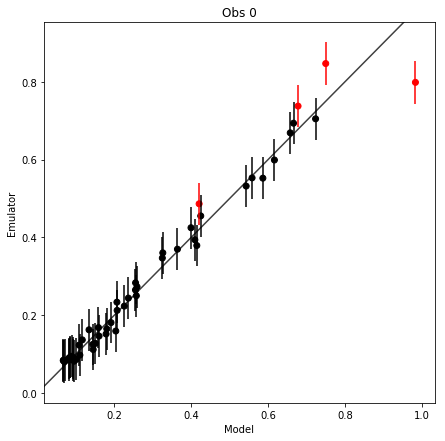

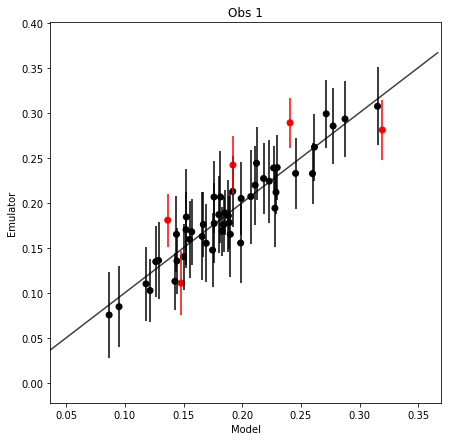

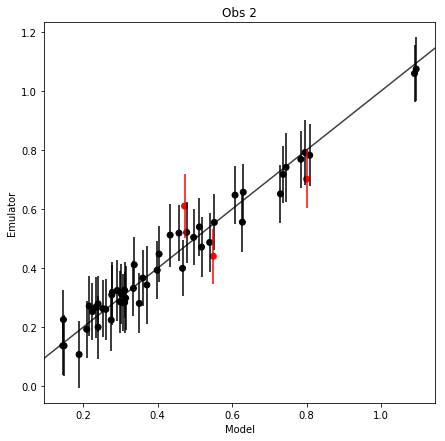

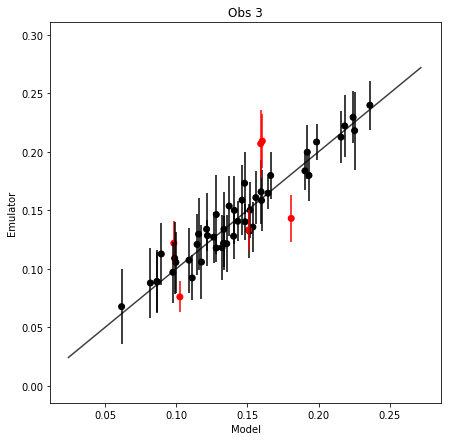

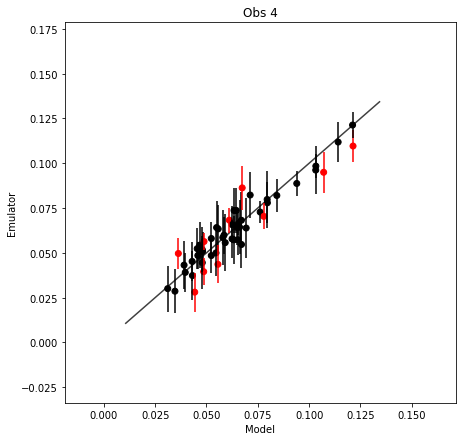

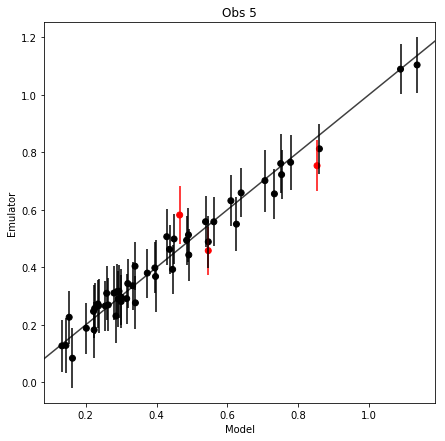

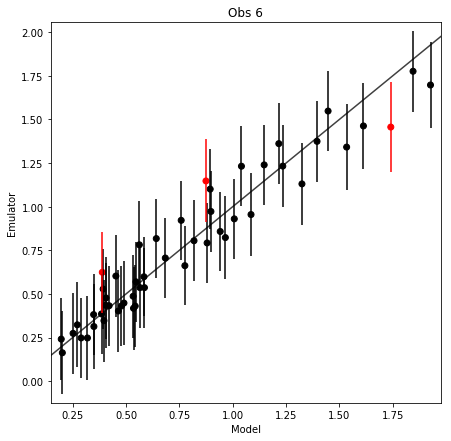

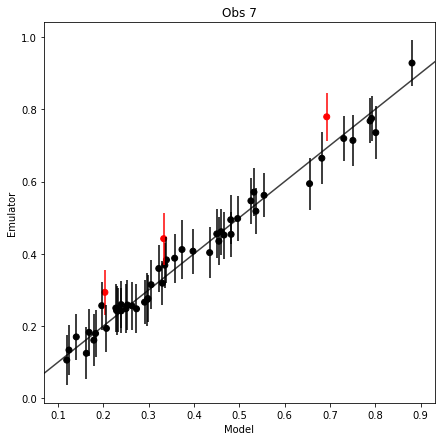

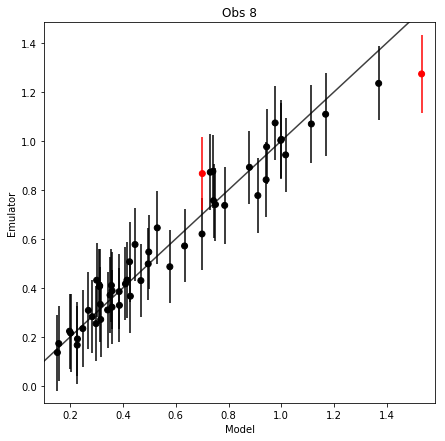

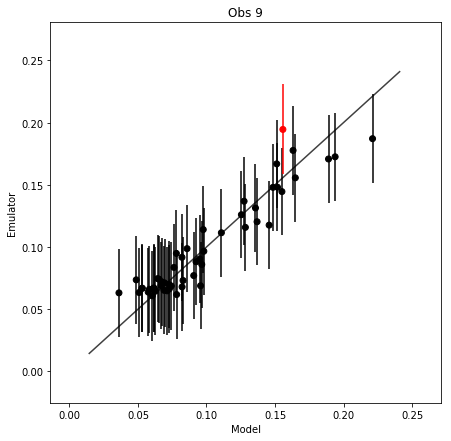

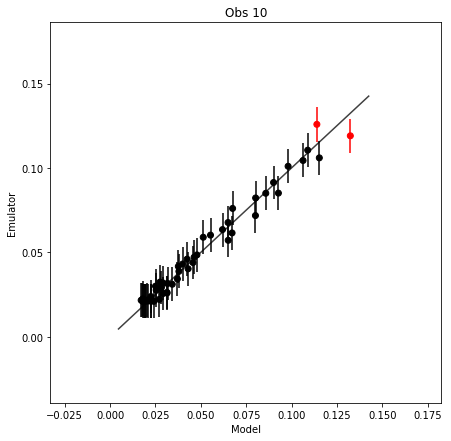

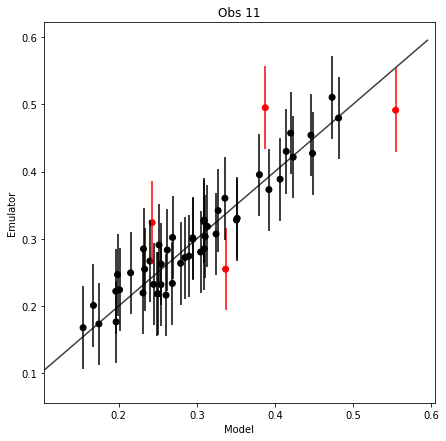

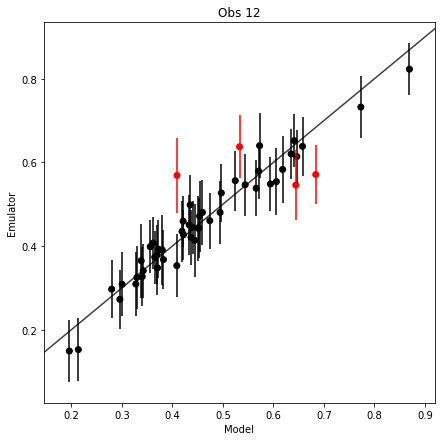

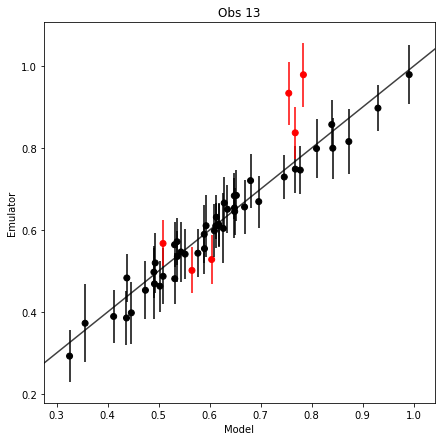

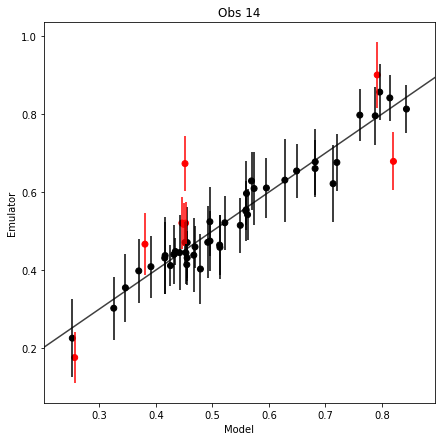

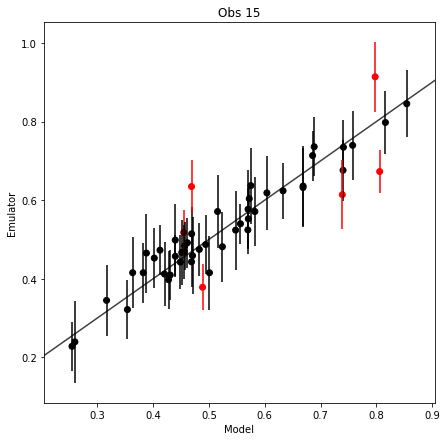

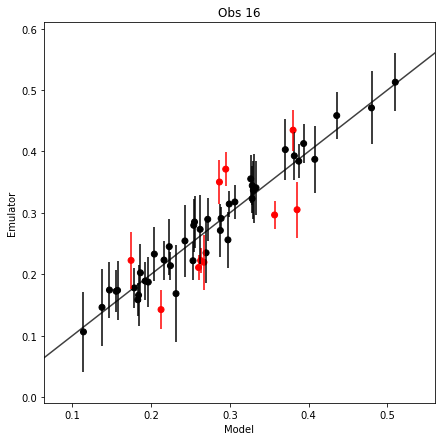

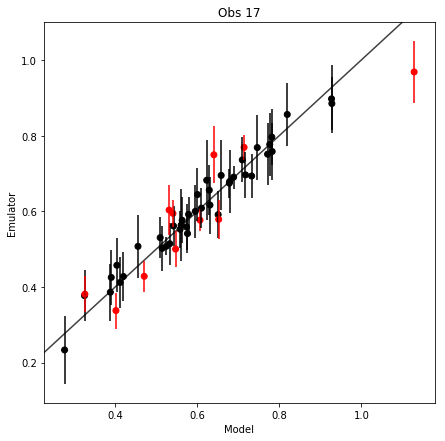

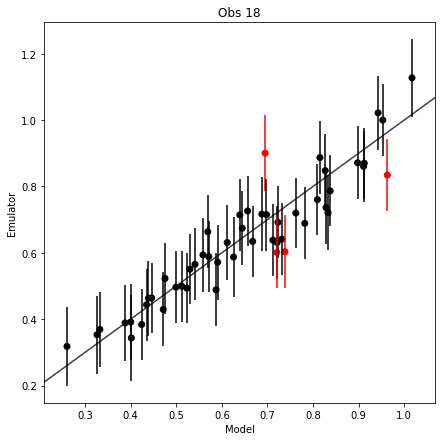

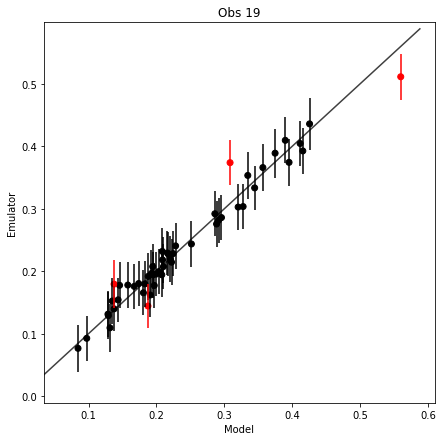

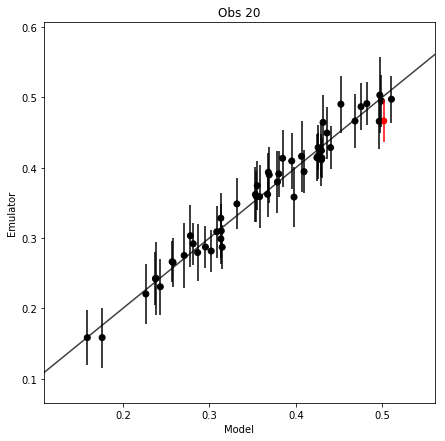

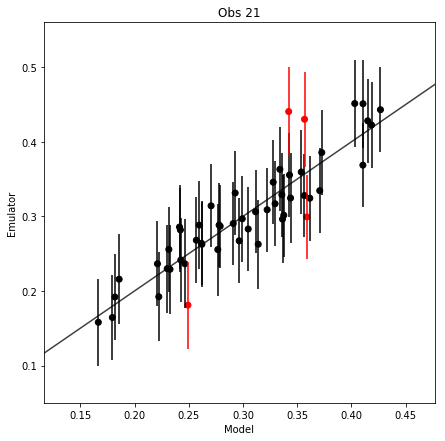

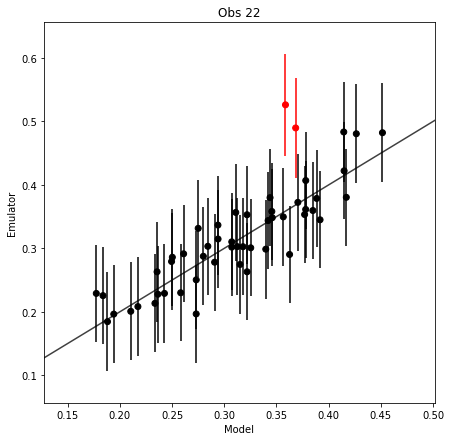

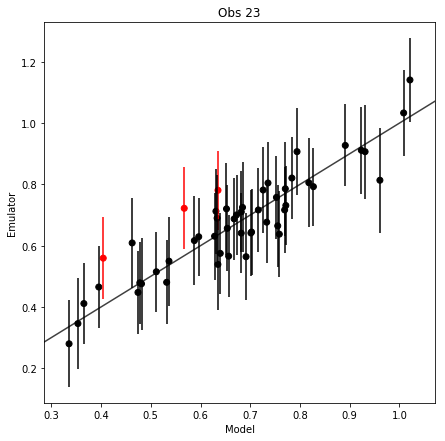

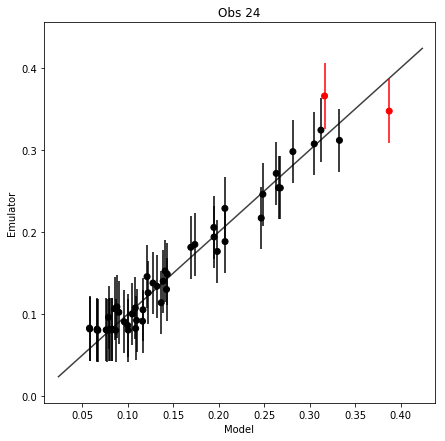

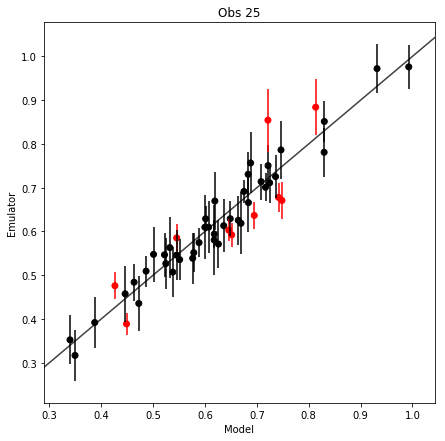

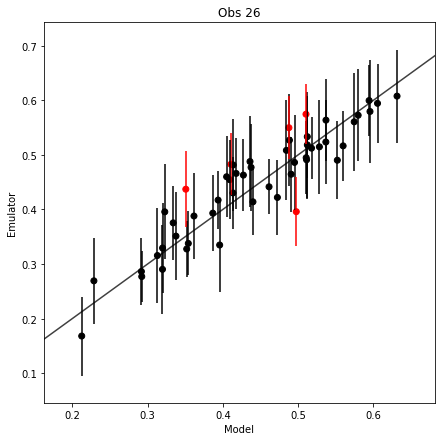

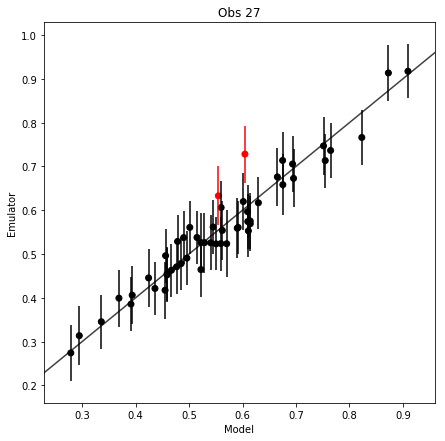

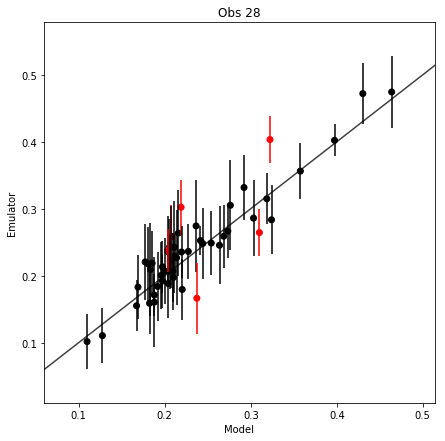

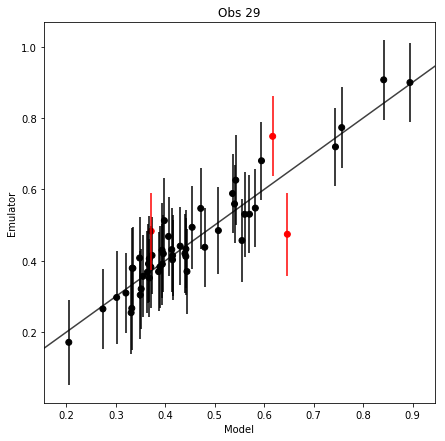

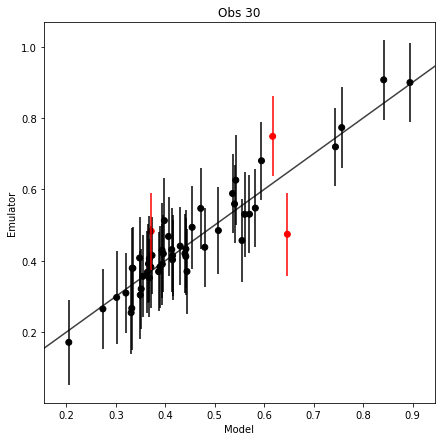

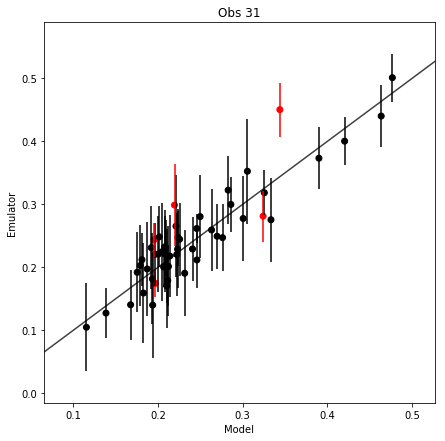

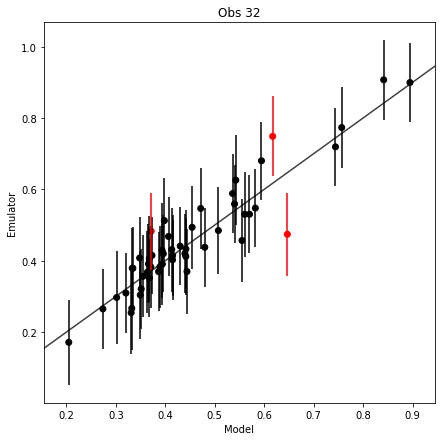

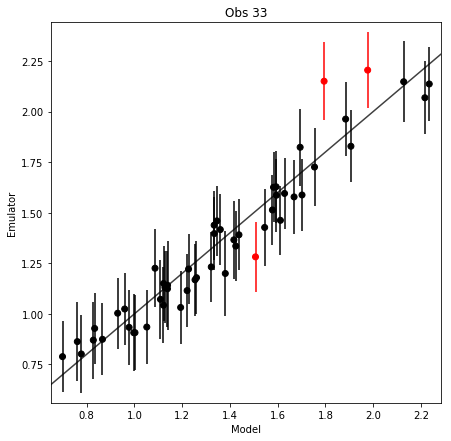

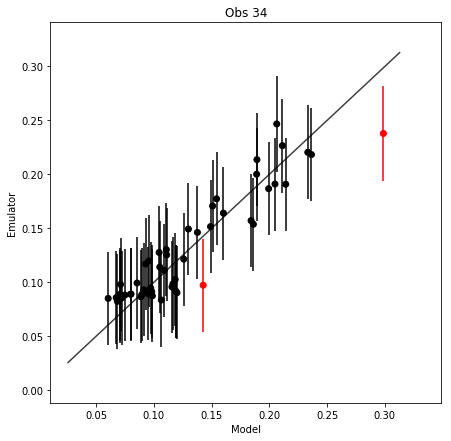

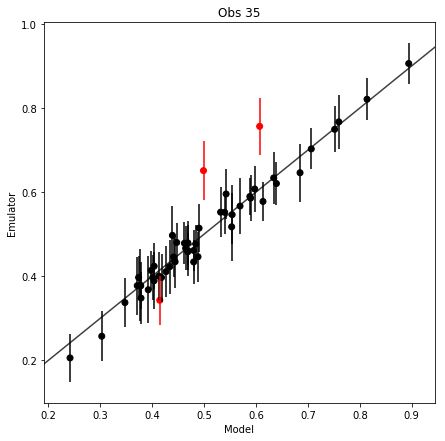

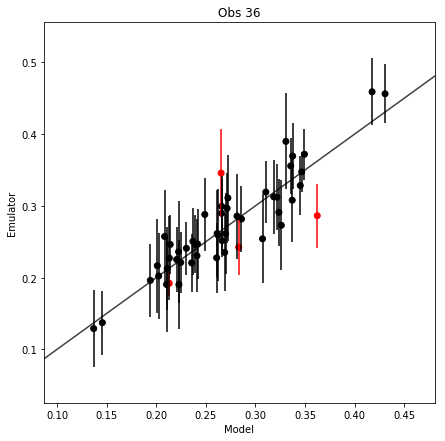

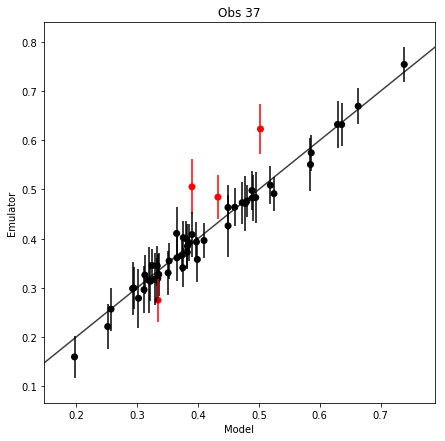

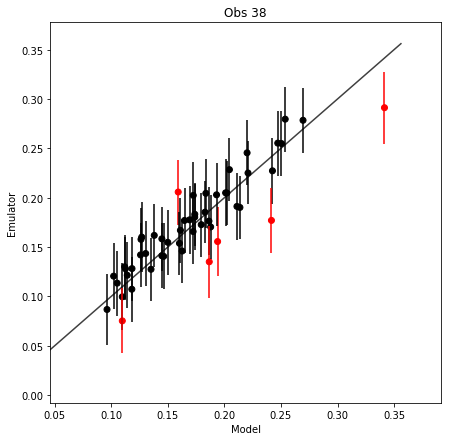

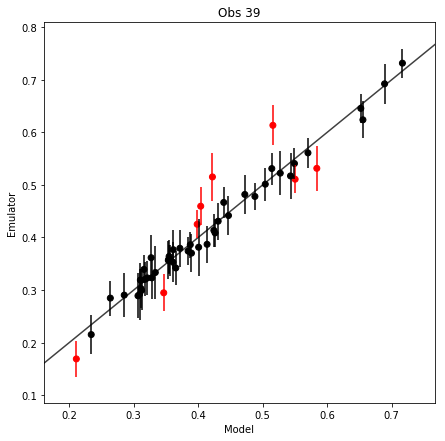

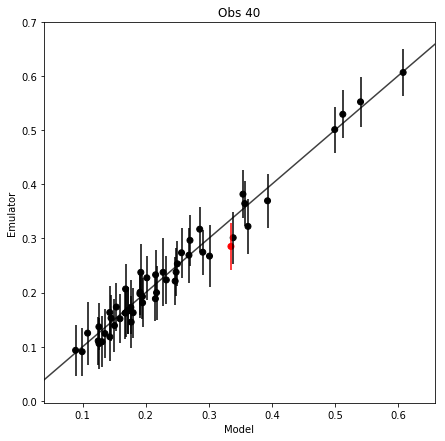

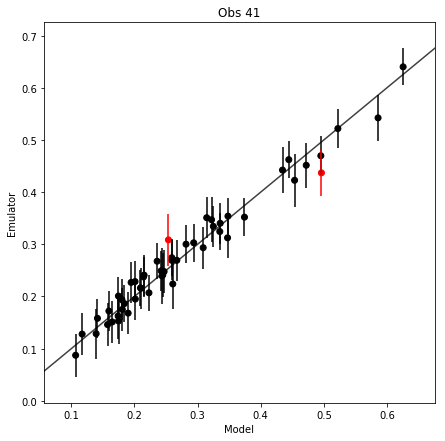

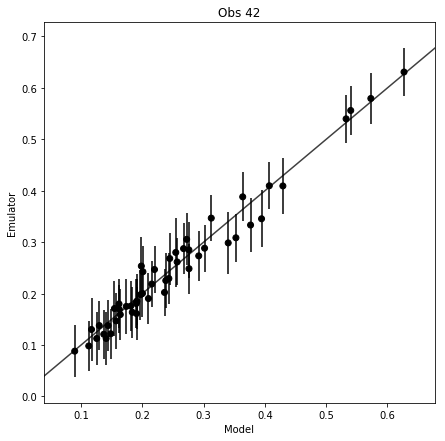

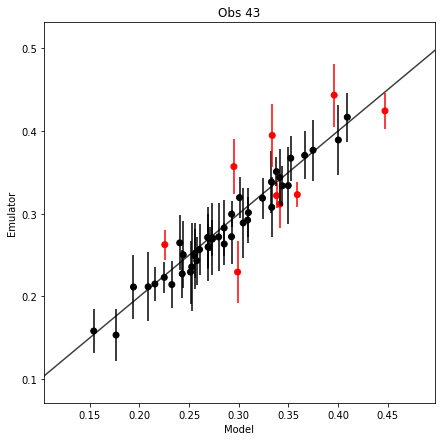

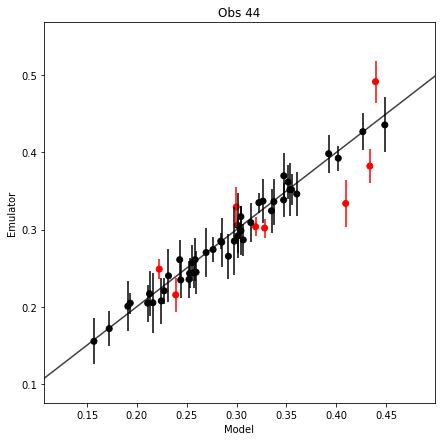

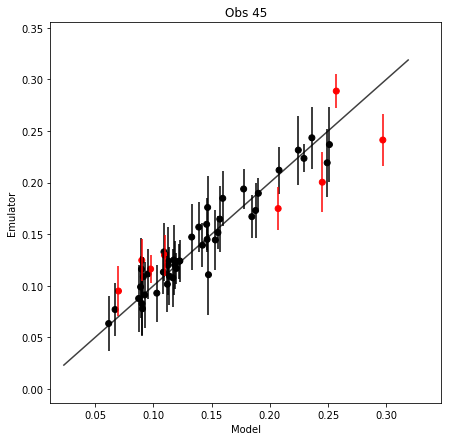

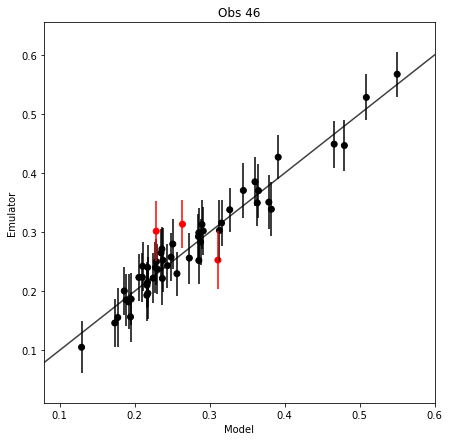

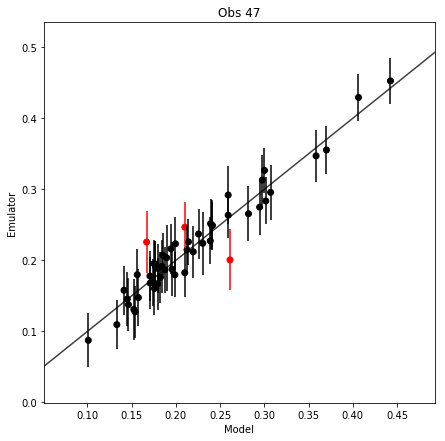

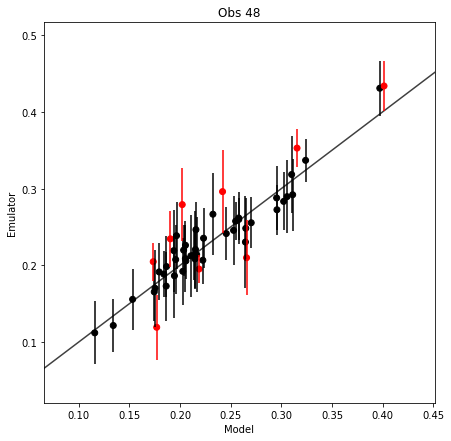

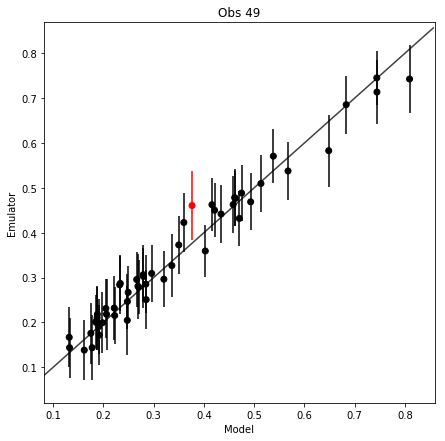

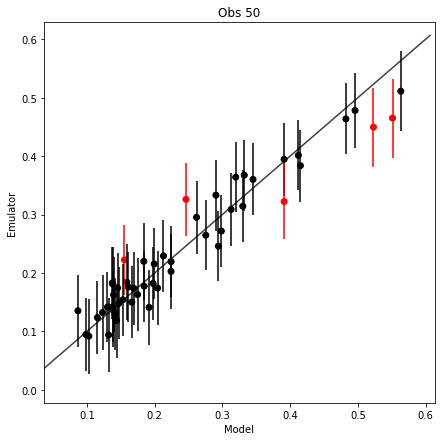

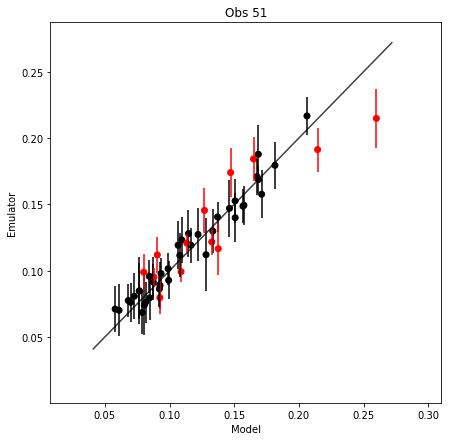

In [15]:
aod_constraint.plot_validation(X_TEST, test_aod.data)

# Constrain the models

Emulating 1e6 sample points directly would require 673 Gb of memory so we can either run 1e6 samples for each point, or run the constraint everywhere, but in sample chunks. Here we do the latter (on the GPU) using the 'naive' algorithm for calculating the variance in batches

In [16]:
all_valid_params, all_implausibility_vals = aod_constraint.constrain_implaus(large_sample, 
                                                                obs_var=10, interann_var=0, repres_var=20, struct_var=0,
                                                                tolerance=.3, threshold=4.0)

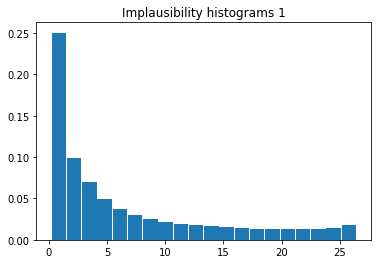

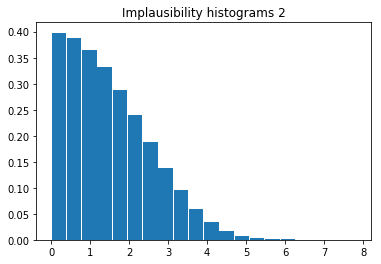

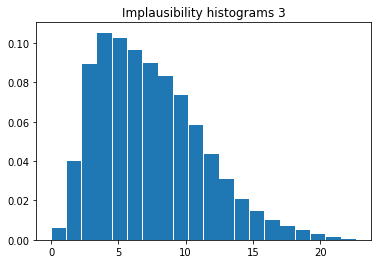

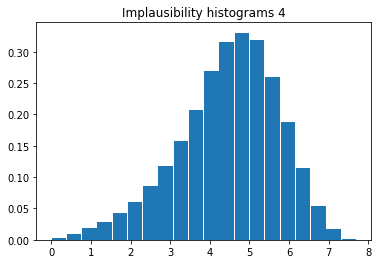

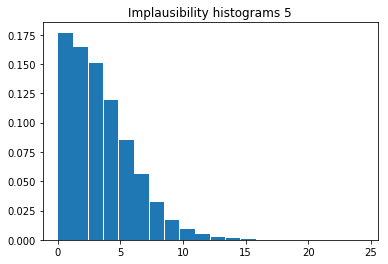

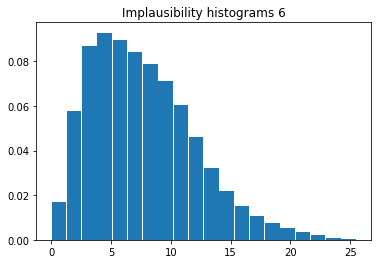

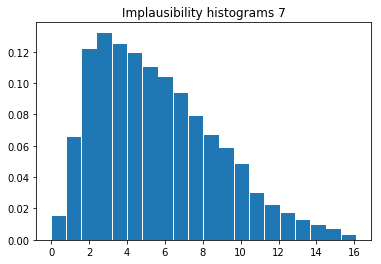

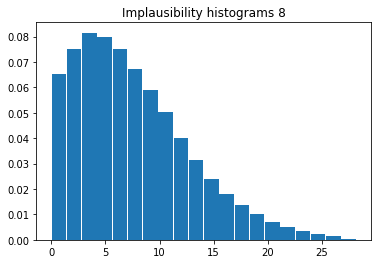

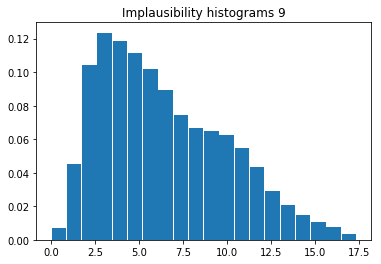

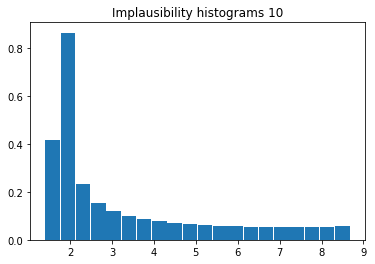

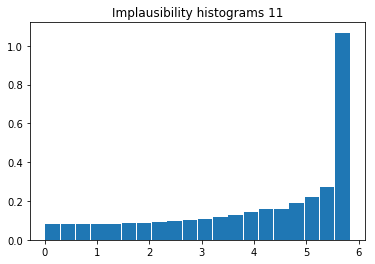

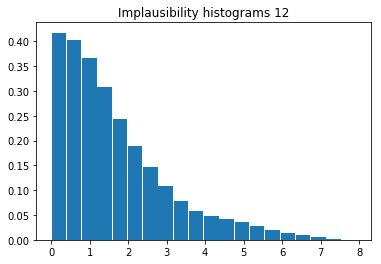

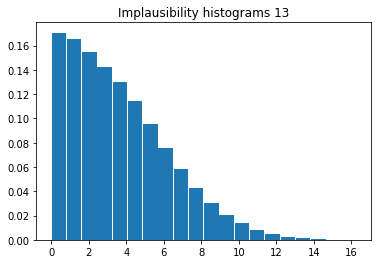

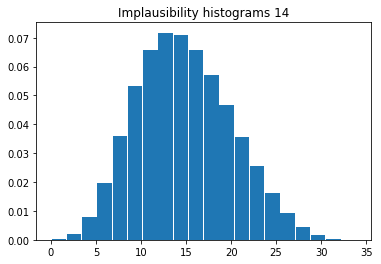

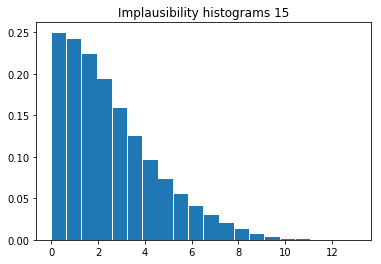

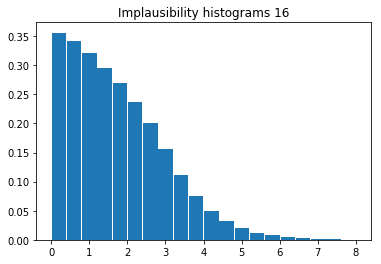

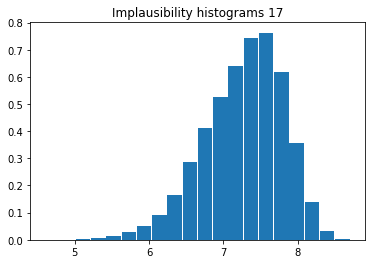

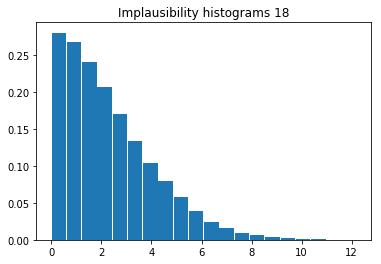

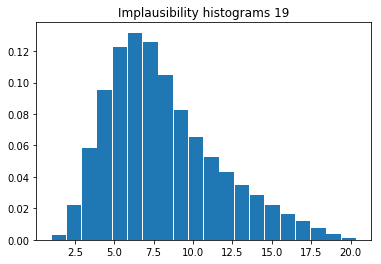

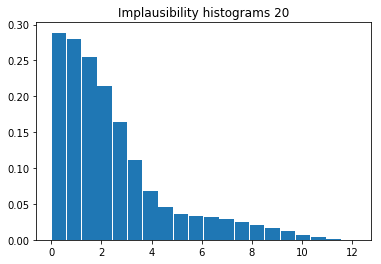

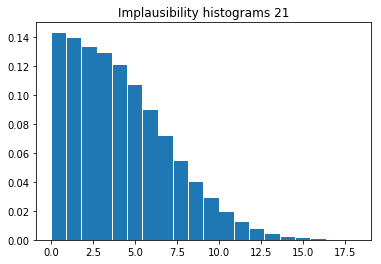

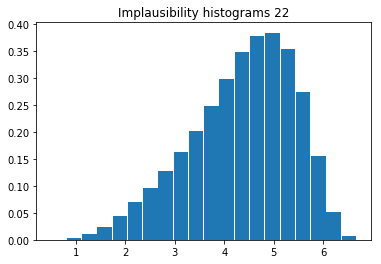

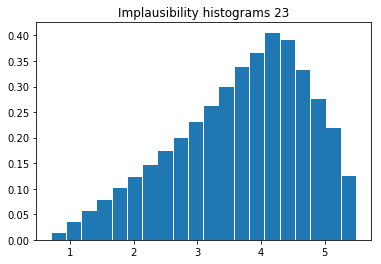

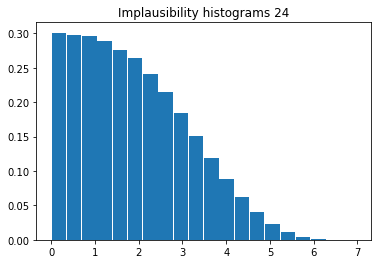

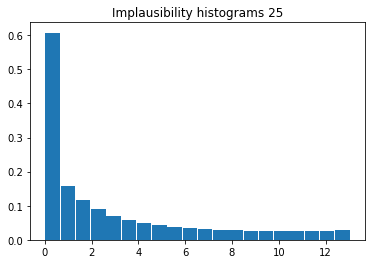

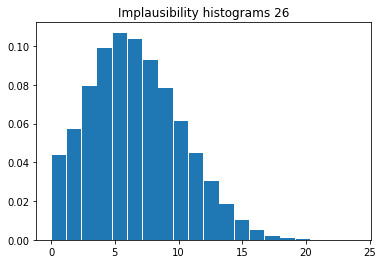

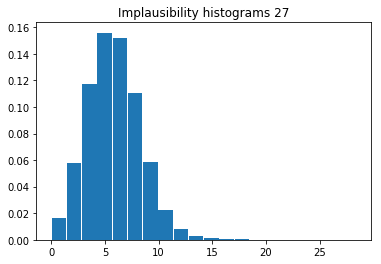

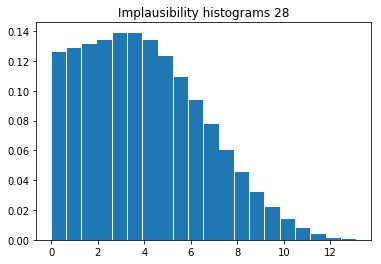

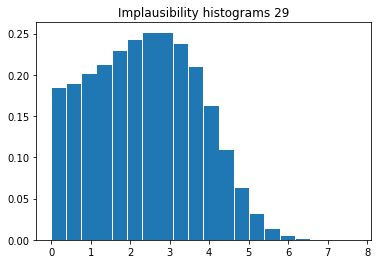

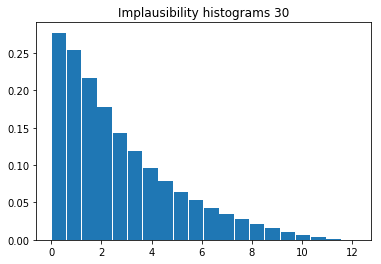

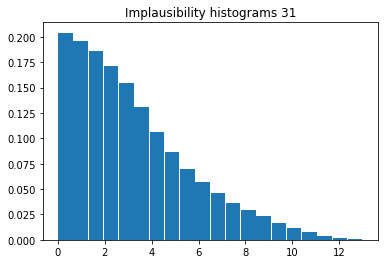

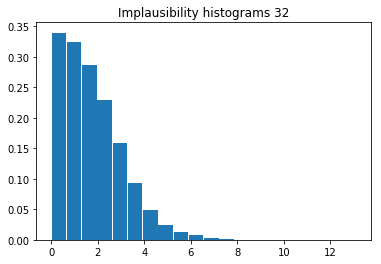

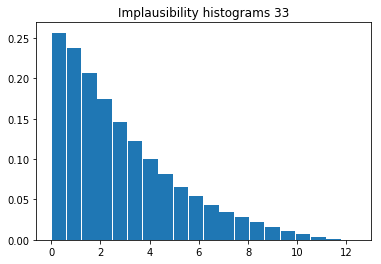

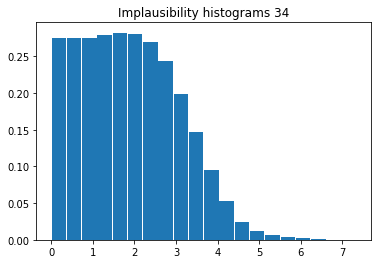

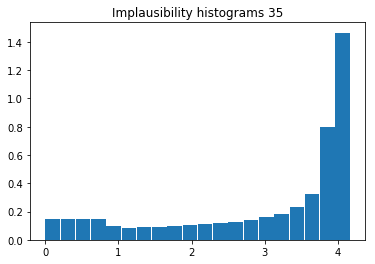

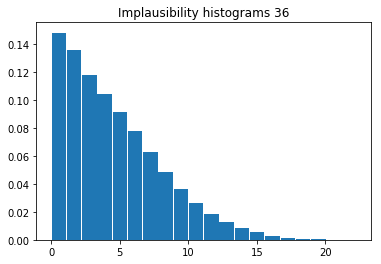

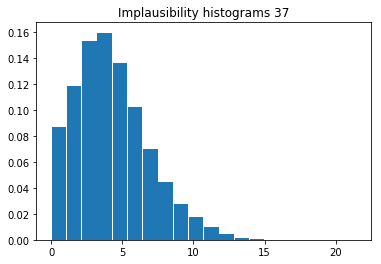

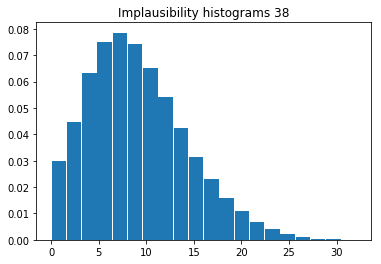

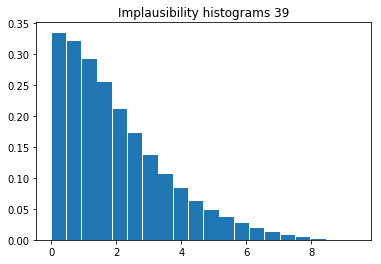

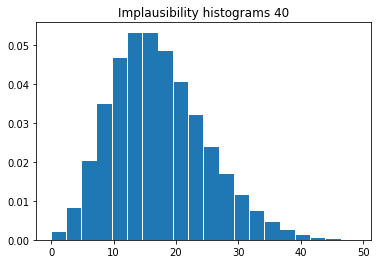

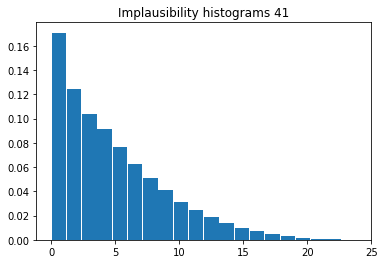

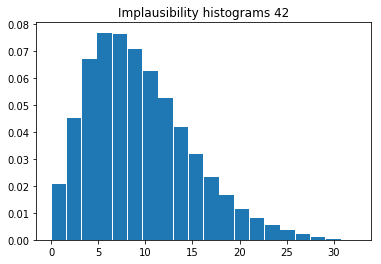

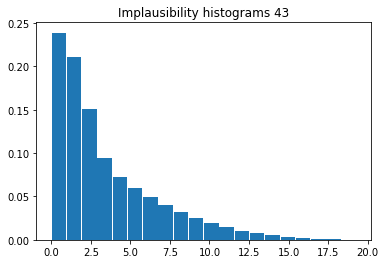

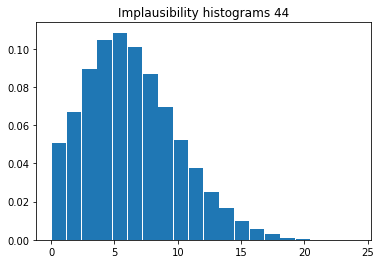

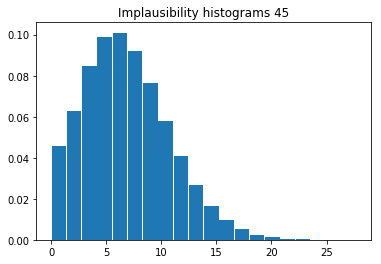

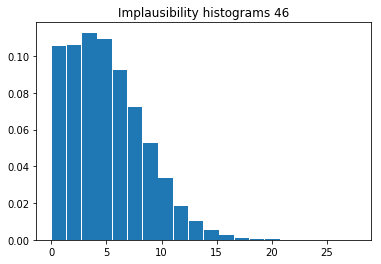

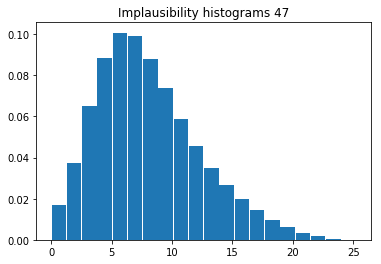

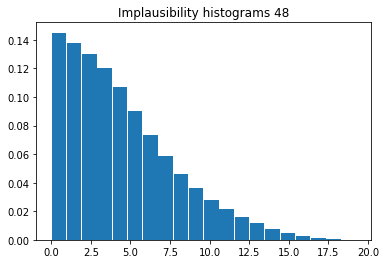

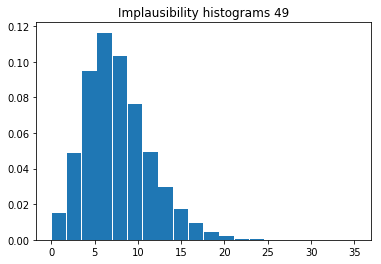

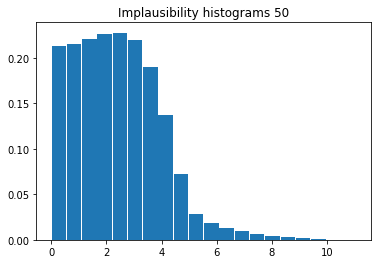

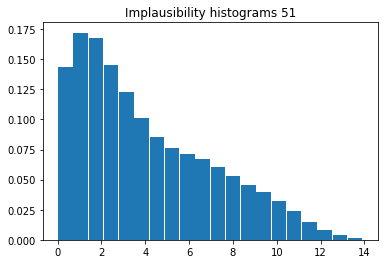

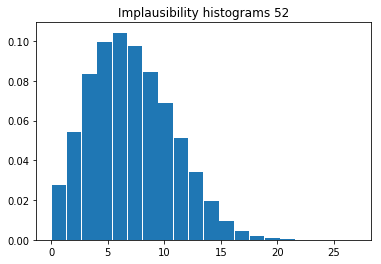

In [17]:
for station in range(52):
    plt.hist(all_implausibility_vals[station, :], bins = 20, histtype='bar', rwidth=0.95, density = True)
    plt.title("Implausibility histograms {}".format(station+1))
    plt.show()

Remaining points: 141621


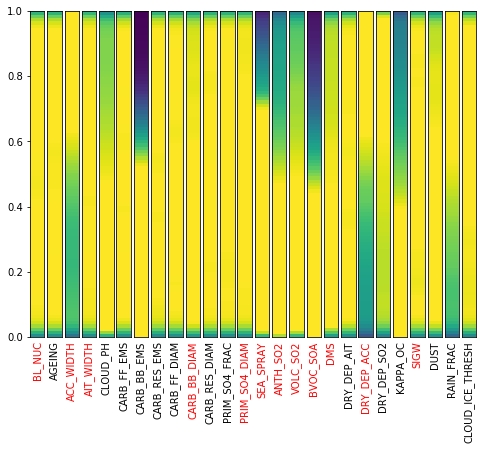

In [18]:
print("Remaining points: {}".format(all_valid_params.sum()))

constrained_sample = large_sample[all_valid_params]

plot_parameter_space(constrained_sample)
plt.show()

In [21]:
ari_model = GPModel(train_ari, "ARI")
ari_model.train(X)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


Fitting using: ['BL_NUC' 'AGEING' 'ACC_WIDTH' 'AIT_WIDTH' 'CLOUD_PH' 'CARB_FF_EMS'
 'CARB_BB_EMS' 'CARB_RES_EMS' 'CARB_FF_DIAM' 'CARB_BB_DIAM'
 'CARB_RES_DIAM' 'PRIM_SO4_FRAC' 'PRIM_SO4_DIAM' 'SEA_SPRAY' 'ANTH_SO2'
 'VOLC_SO2' 'BVOC_SOA' 'DMS' 'DRY_DEP_AIT' 'DRY_DEP_ACC' 'DRY_DEP_SO2'
 'KAPPA_OC' 'SIGW' 'DUST' 'RAIN_FRAC' 'CLOUD_ICE_THRESH']


         Current function value: -6591825.860246
         Iterations: 315
         Function evaluations: 436
         Gradient evaluations: 424
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -6591825.860246
  Number of iterations: 315
  Number of functions evaluations: 436


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -6591825.860246
  Number of iterations: 315
  Number of functions evaluations: 436


In [22]:
unconstrained_ari = ari_model.sample(large_sample) 
constrained_ari = ari_model.sample(constrained_sample)

Original: 0.29, Current: 0.23
Proportion of original spread: 81%


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


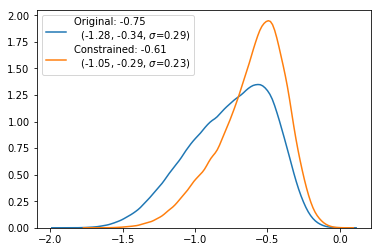

In [23]:
plot_histogram_comparison(np.concatenate(constrained_ari[2]), np.concatenate(unconstrained_ari[2]))

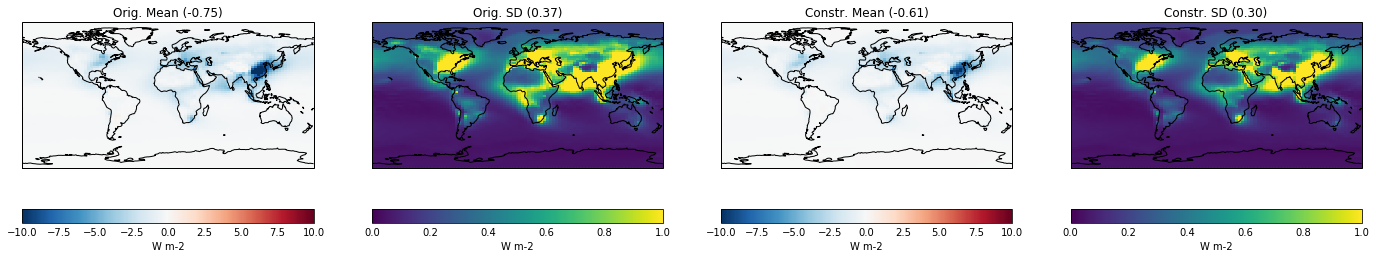

In [24]:
plot_maps(unconstrained_ari[0], unconstrained_ari[1], constrained_ari[0], constrained_ari[1],
         titles=['Orig. Mean', 'Orig. SD', 'Constr. Mean', 'Constr. SD'],
         subplot_kws=[dict(vmin=-10, vmax=10, cmap='RdBu_r'),
                     dict(vmin=0, vmax=1),
                     dict(vmin=-10, vmax=10, cmap='RdBu_r'),
                     dict(vmin=0, vmax=1)])